# Установка пакетов

In [ ]:
!pip install boto3

# Импорт пакетов

In [ ]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import io
import datetime as dt
import numpy as np
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
s3 = boto3.resource('s3',
                endpoint_url='https://storage.yandexcloud.net',
                region_name = 'ru-central1',
                aws_access_key_id = ..., # your key
                aws_secret_access_key = ..., # your key
                )
data_bucket = s3.Bucket('otus-mlops-hw2')

Анализ проводился в google colab. В память не влезали целые файлы, поэтому считывалось первые n байт. Возможна ситуация, когда ошибка в данных встречалась в конце файла, тогда она не была обнаружена. Предполагаю, что ошибки в данных распределены равномерно во всем датасете.

## Проверка подключения

In [ ]:
count = sum(1 for _ in data_bucket.objects.all())
print(f'{count} файлов')

40 файлов


# Проверка корректности данных

## 1. Проверка полноты данных

In [ ]:
def check_data(data, cols, n_bytes = 1000000):
    txt = data.get().get('Body').read(n_bytes).decode()
    header = txt.split('\n')[0]
    body = '\n'.join(txt.split('\n')[1:-1])
    header = [i.strip() for i in header.replace('#', '').split('|')]
    df= pd.read_csv(io.StringIO(body),sep=',', engine = 'python', names=header)
    columns = df.columns.tolist()
    for new_c in columns:
        if new_c not in cols.keys():
            print(f'Обнаружен новый столбец {new_c}')
            cols[new_c] = dict()
            cols[new_c].update({'dtype': [df[new_c].dtype],
                                'NA': [df[new_c].isna().sum()],
                                'nrows': [df.shape[0]]
                                })
        else:
            cols[new_c]['dtype'].append(df[new_c].dtype)
            cols[new_c]['NA'].append(df[new_c].isna().sum())
            cols[new_c]['nrows'].append(df.shape[0])
    for old_c in cols.keys():
        if old_c not in columns:
            print(f'{old_c} нет в списке столбцов!')
    return cols # Dict[colname: [List of dtypes]]

def read_csv(s3obj, n_bytes = 10000):
    txt = data.get().get('Body').read(n_bytes).decode()
    header = txt.split('\n')[0]
    body = '\n'.join(txt.split('\n')[1:-1])
    header = [i.strip() for i in header.replace('#', '').split('|')]
    df= pd.read_csv(io.StringIO(body),sep=',', engine = 'python', names=header)
    return df

In [ ]:
cols = dict()
for data in data_bucket.objects.all():
    print(f'========= {data.key} ========')
    cols = check_data(data, cols)

========= fraud-data/2019-08-22.txt ========
Обнаружен новый столбец tranaction_id
Обнаружен новый столбец tx_datetime
Обнаружен новый столбец customer_id
Обнаружен новый столбец terminal_id
Обнаружен новый столбец tx_amount
Обнаружен новый столбец tx_time_seconds
Обнаружен новый столбец tx_time_days
Обнаружен новый столбец tx_fraud
Обнаружен новый столбец tx_fraud_scenario
========= fraud-data/2019-09-21.txt ========
========= fraud-data/2019-10-21.txt ========
========= fraud-data/2019-11-20.txt ========
========= fraud-data/2019-12-20.txt ========
========= fraud-data/2020-01-19.txt ========
========= fraud-data/2020-02-18.txt ========
========= fraud-data/2020-03-19.txt ========
========= fraud-data/2020-04-18.txt ========
========= fraud-data/2020-05-18.txt ========
========= fraud-data/2020-06-17.txt ========
========= fraud-data/2020-07-17.txt ========
========= fraud-data/2020-08-16.txt ========
========= fraud-data/2020-09-15.txt ========
========= fraud-data/2020-10-15.txt ==

Во всех файлах одинаковые столбцы

In [ ]:
summary = pd.DataFrame(columns=['dtype', 'NA', 'nrows'])
for key, value in cols.items():
    row = pd.Series(value)
    row['NA'] = sum(row['NA'])
    row['nrows'] = sum(row['nrows'])
    row['dtype'] = set(row['dtype'])
    summary.loc[key] = row
summary['%NA'] = summary['NA'] / summary['nrows']
summary

,dtype,NA,nrows,%NA
tranaction_id,{int64},0,646031,0.0
tx_datetime,{object},0,646031,0.0
customer_id,{int64},0,646031,0.0
terminal_id,"{int64, object}",3,646031,0.000005
tx_amount,{float64},0,646031,0.0
tx_time_seconds,{int64},0,646031,0.0
tx_time_days,{int64},0,646031,0.0
tx_fraud,{int64},0,646031,0.0
tx_fraud_scenario,{int64},0,646031,0.0


Некоторые столбцы представлены несколькими типами данных. Количество пропусков на сэмпле данных не превышает <0.01% процентов.

## 2. Поиск выбросов

Файлов немного, можно посмотреть распреление данных "глазами". Если бы их было больше, можно было делать рандомный сэмпл из файлов. Проанализировать распределение данных в этом сэмпле и распространить на всю выборку.

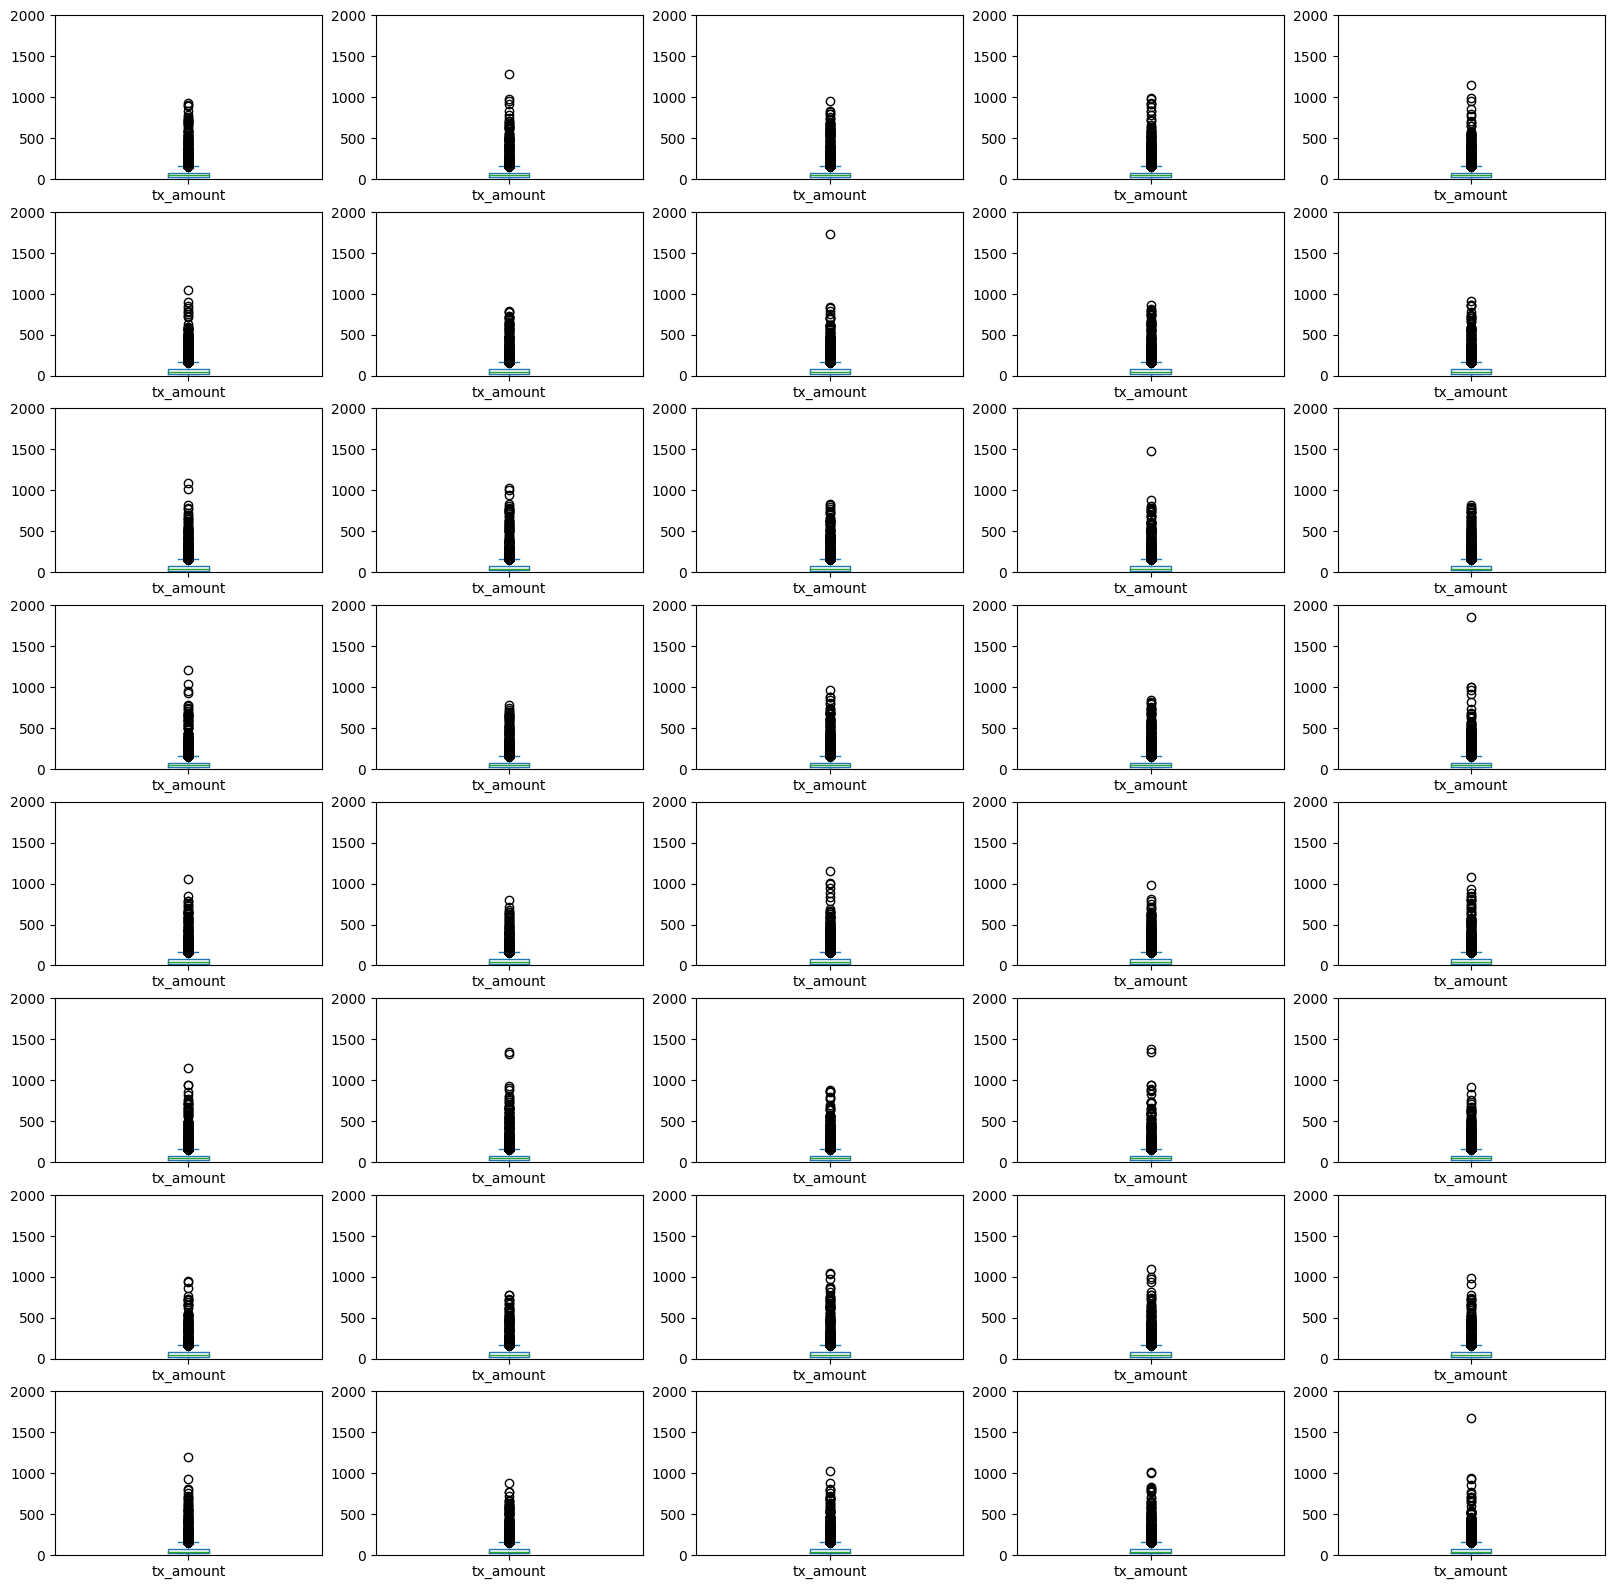

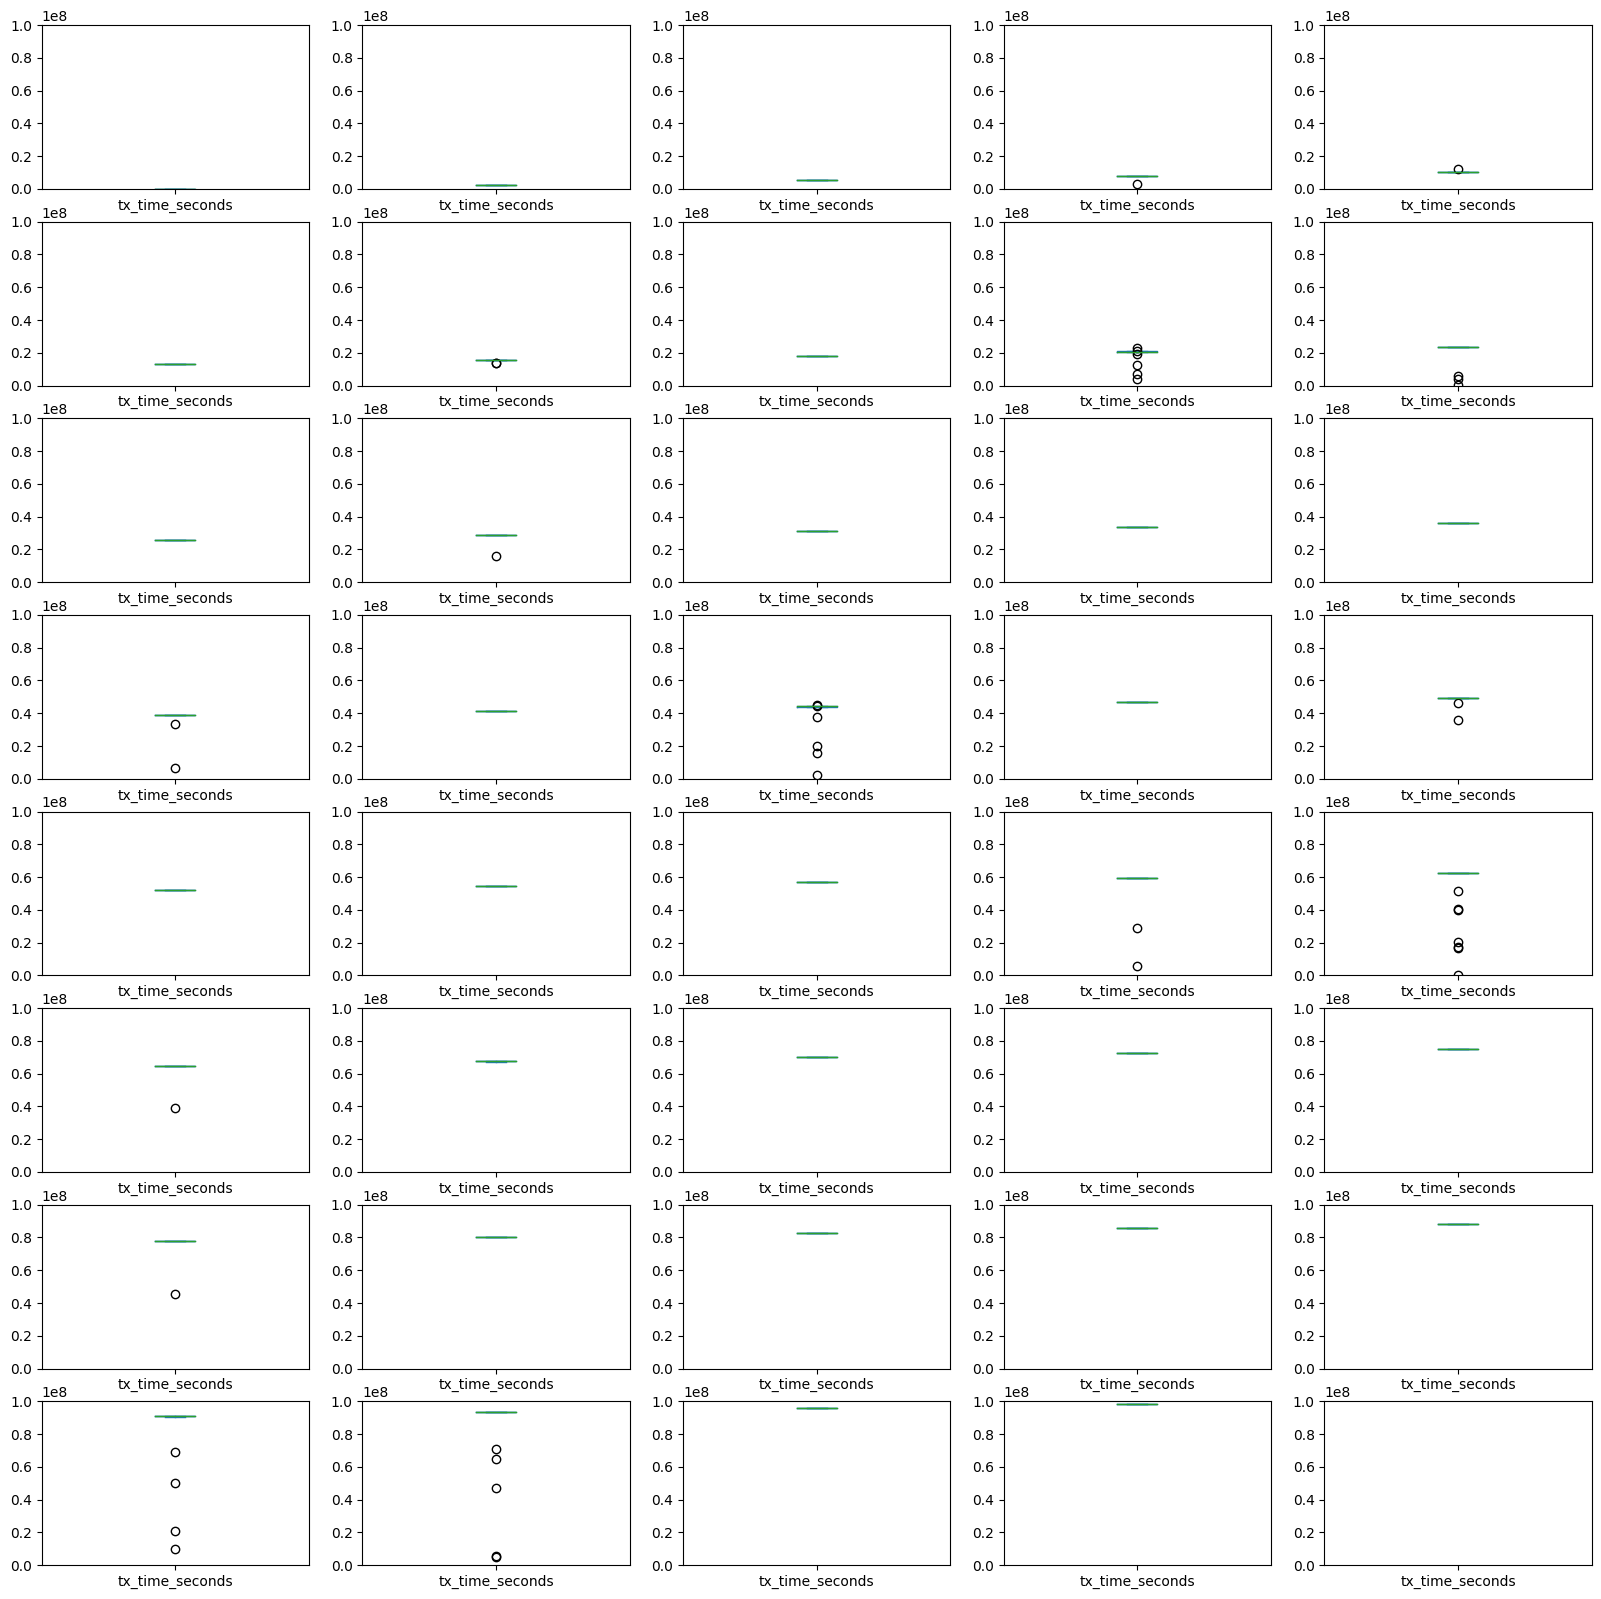

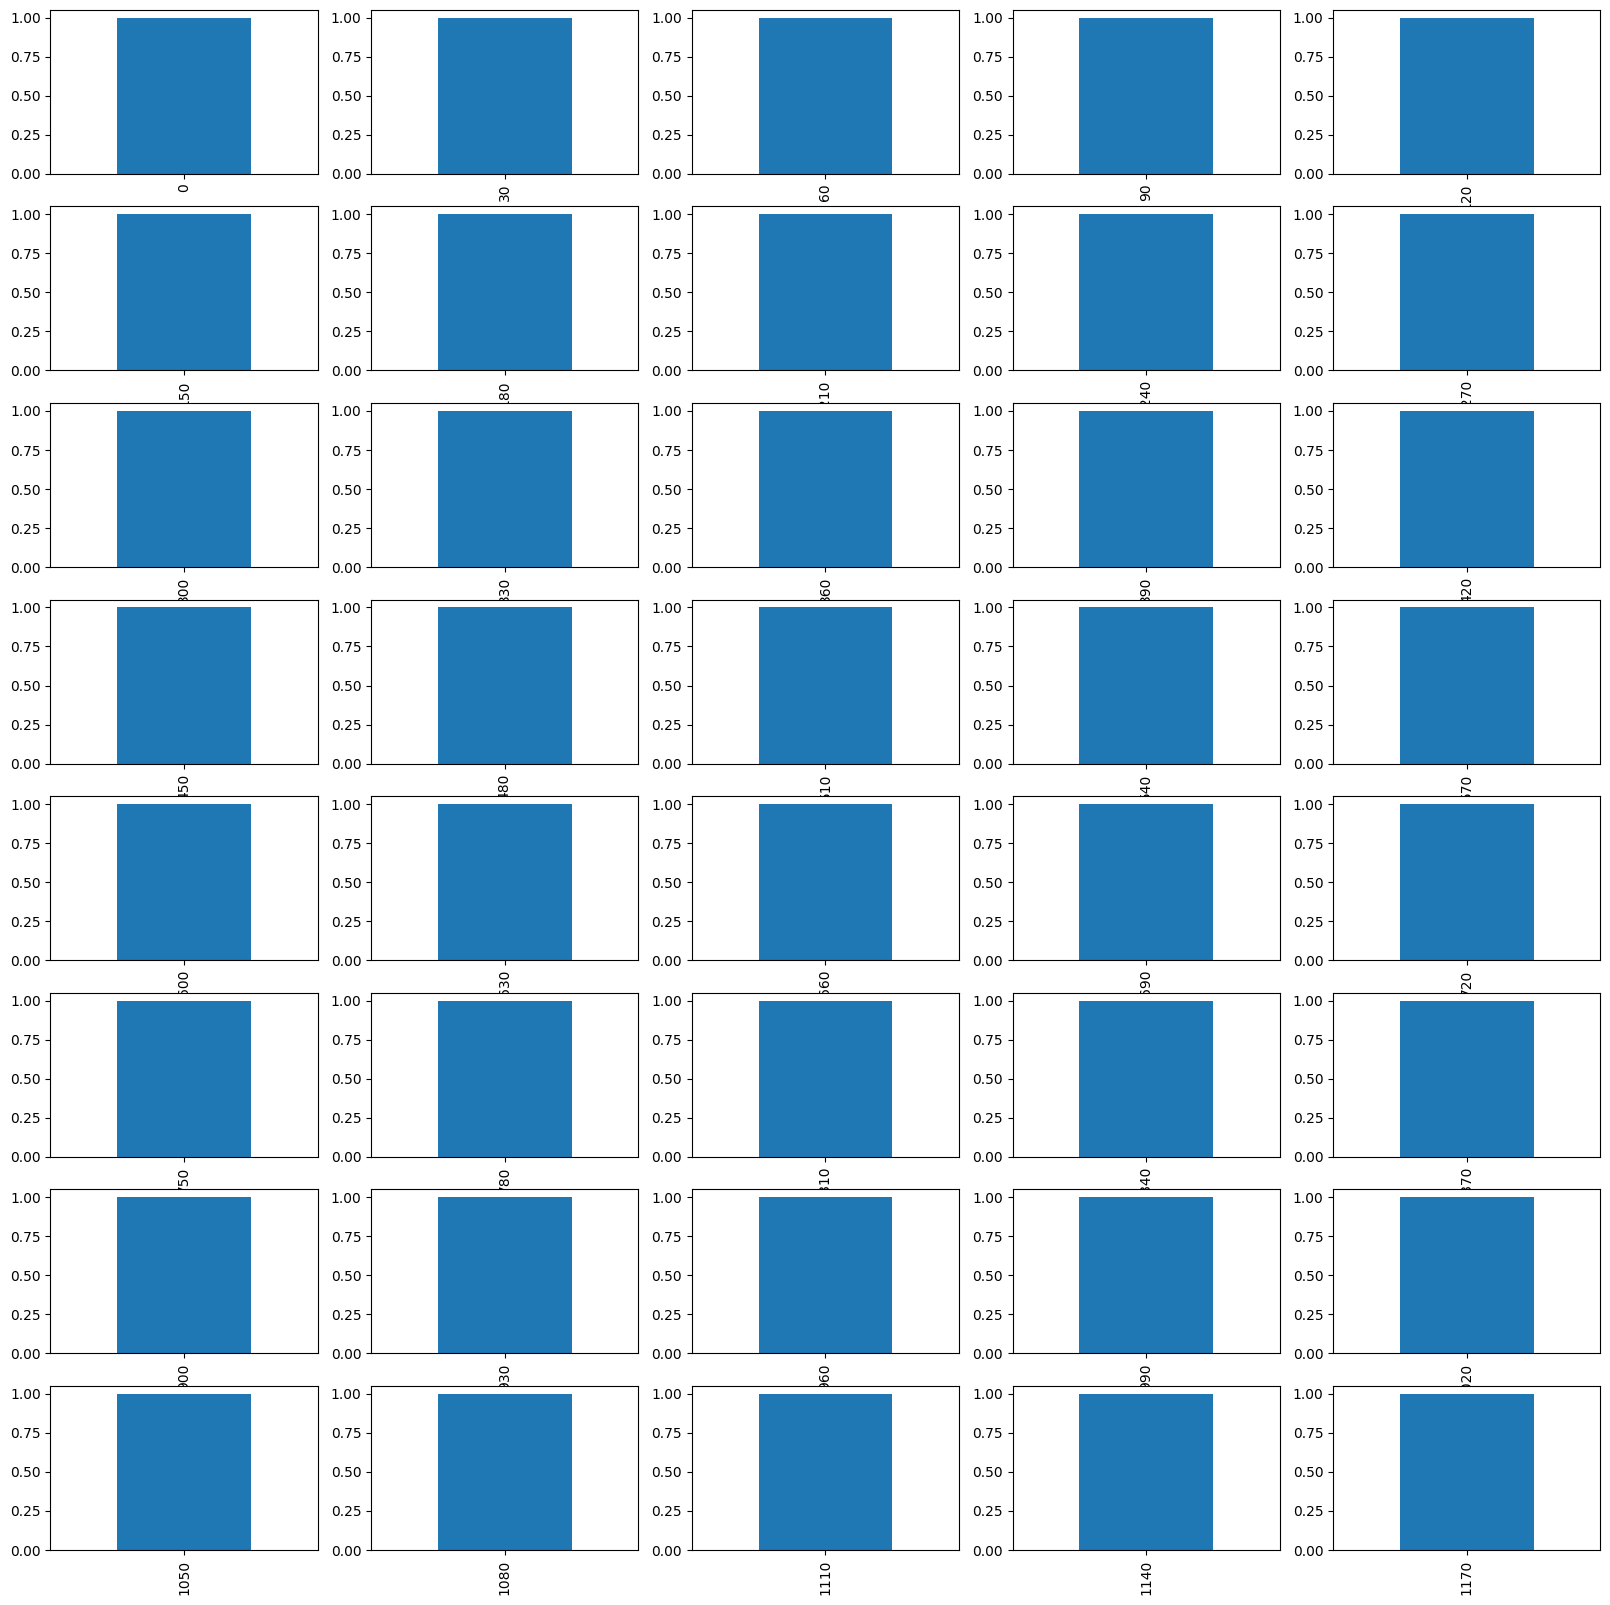

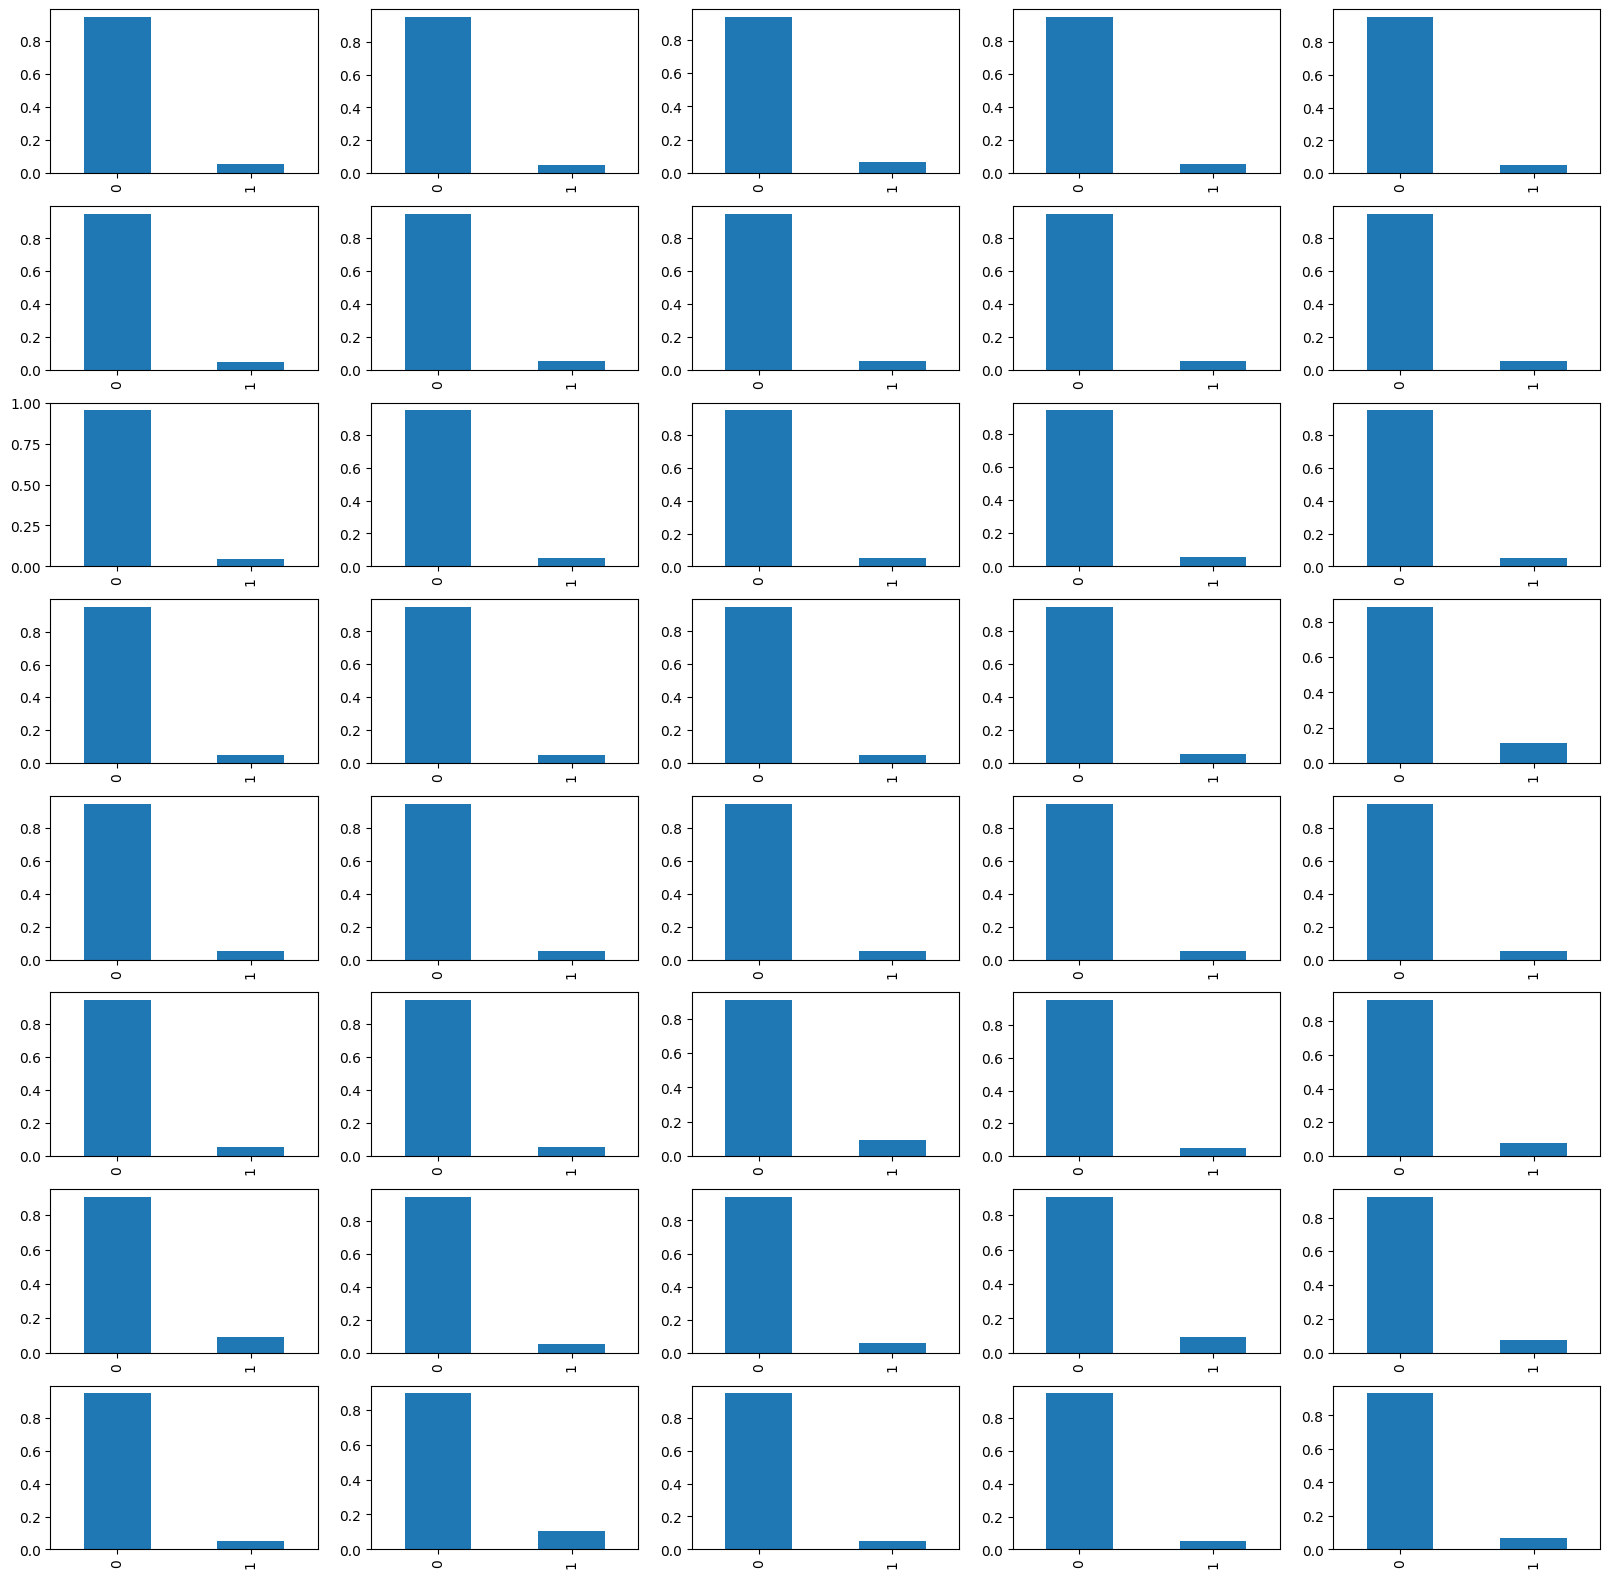

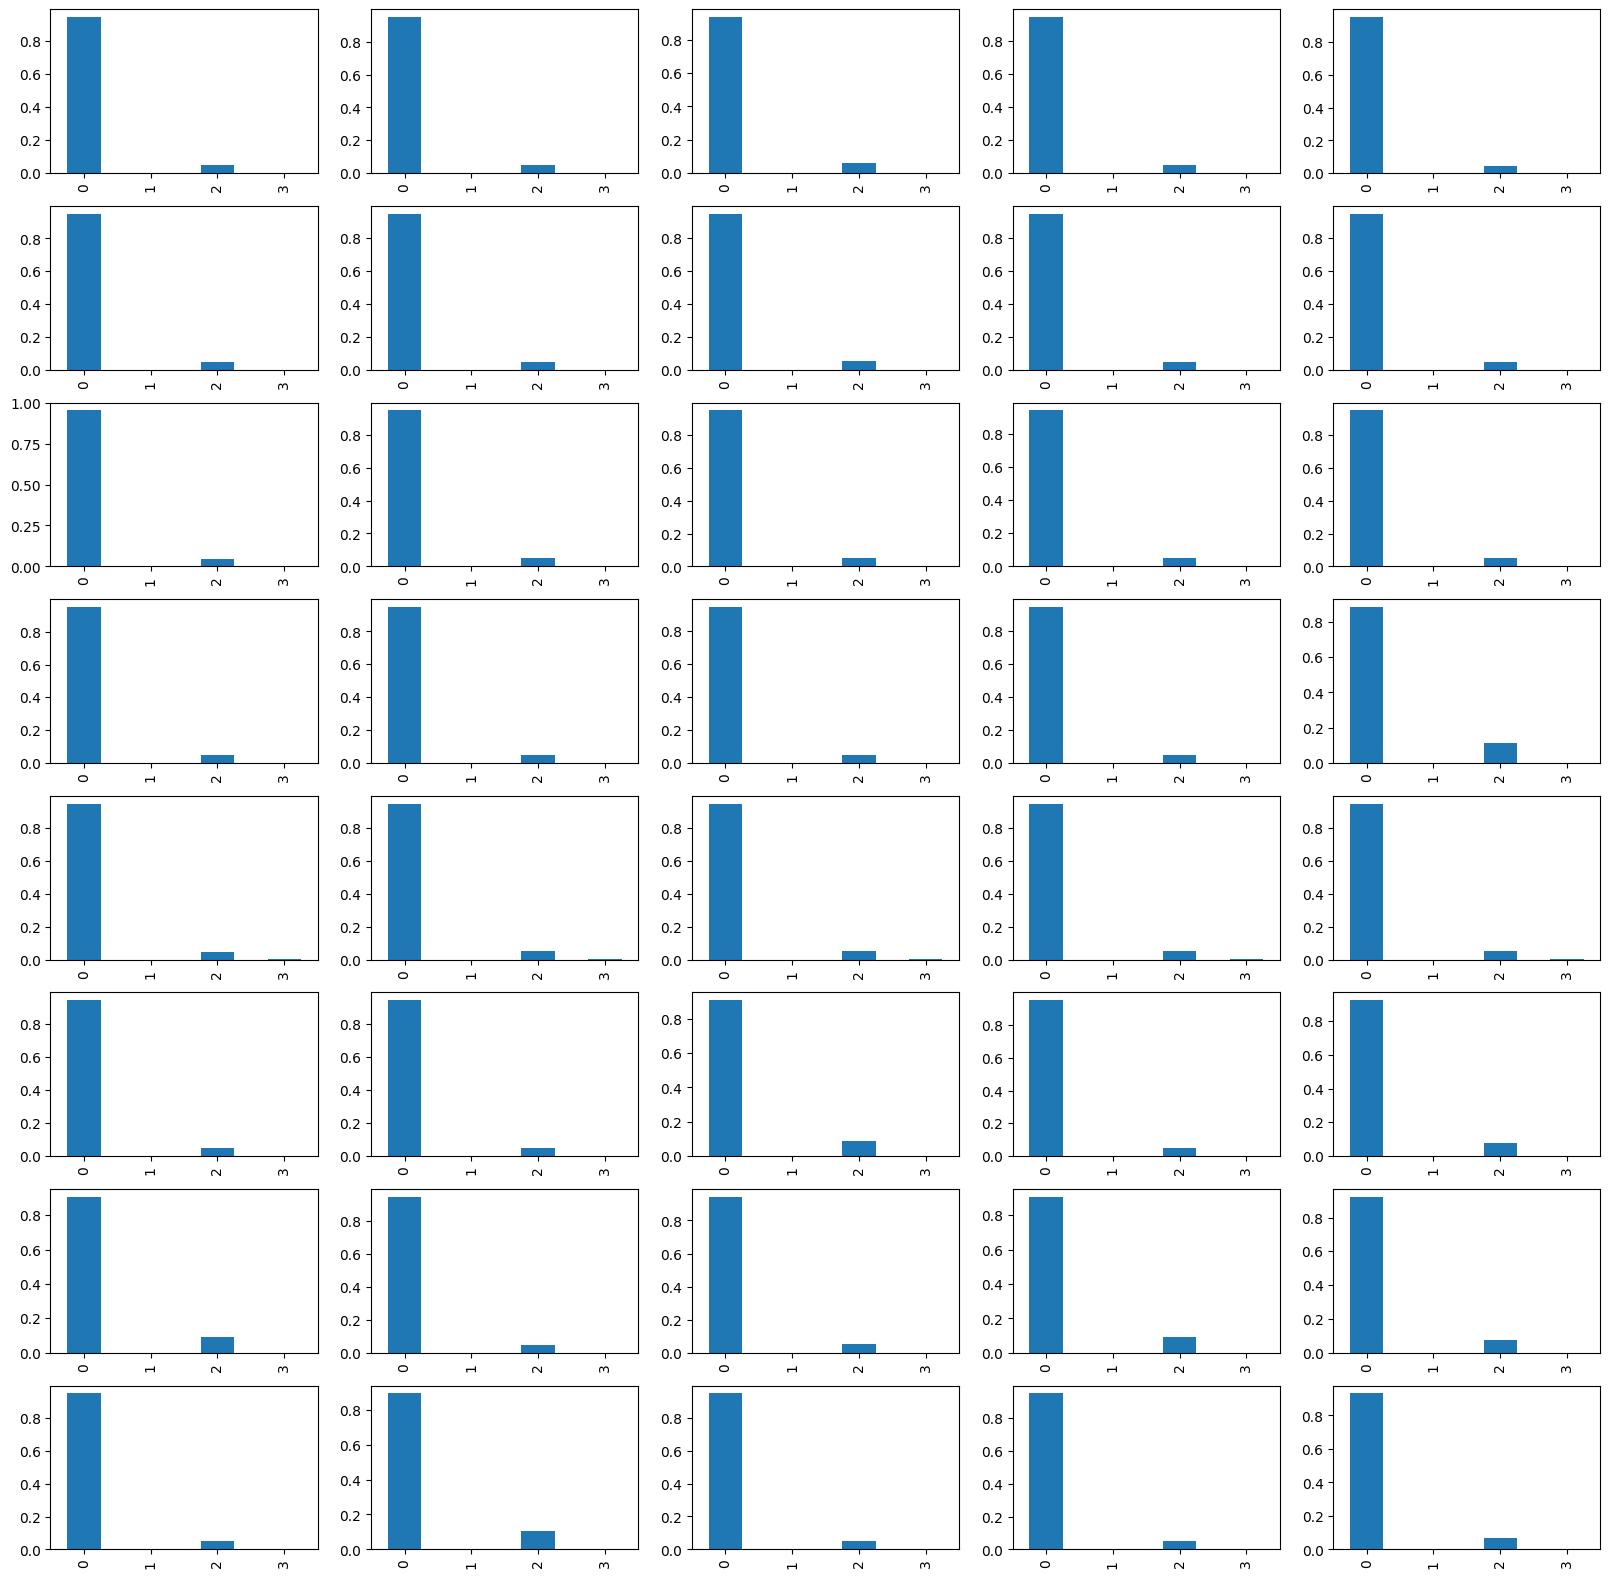

In [ ]:
tx_amount, tx_amount_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_seconds, tx_time_seconds_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_days, tx_time_days_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_fraud, tx_fraud_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_fraud_scenario, tx_fraud_scenario_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))

[[i.set_ylim(0, 2000) for i in row] for row in tx_amount_ax]
[[i.set_ylim(0, 10**8) for i in row] for row in tx_time_seconds_ax]

n_row, n_col = 0, 0
for data in data_bucket.objects.all():
    df = read_csv(data, n_bytes = 10000000)
    df['tx_amount'].plot.box(ax=tx_amount_ax[n_row, n_col])
    df['tx_time_seconds'].plot.box(ax=tx_time_seconds_ax[n_row, n_col])
    df['tx_time_days'].value_counts(normalize=True).sort_index().plot.bar(ax=tx_time_days_ax[n_row, n_col])
    df['tx_fraud'].value_counts(normalize=True).sort_index().plot.bar(ax=tx_fraud_ax[n_row, n_col])
    df['tx_fraud_scenario'].value_counts(normalize=True).sort_index().plot.bar(ax=tx_fraud_scenario_ax[n_row, n_col])
    n_row = n_row if n_col + 1 < 5 else n_row + 1
    n_col = n_col + 1 if n_col < 4 else 0

В `tx_amount` присутствуют выбросы, что видно на боксплоте.

В столбце`tx_time_seconds` тоже явно присутсвуют экстремальные значения.

В стобцах `tx_fraud` и `tx_fraud_scenario` присутствует перекос данных. В `tx_fraud_scenario` **1** и **3** значений очень мало. Но описания данных нет, и судить - выброс это или нет, нельзя.

## Проверка дат

In [ ]:
import numpy as np

def check_datetime_format(dt):
    year, month, day, hour, minute, sec = [], [], [], [], [], []
    bad = []
    for i in dt:
        try:
            date, time = i.split()
            Y = int(date.split('-')[0])
            m = int(date.split('-')[1])
            d = int(date.split('-')[2])
            H = int(time.split(':')[0])
            M = int(time.split(':')[1])
            S = int(time.split(':')[2])

            if Y not in year:
                year.append(int(Y))
            if m not in month:
                month.append(int(m))
            if d not in day:
                day.append(int(d))
            if H not in hour:
                hour.append(int(H))
            if M not in minute:
                minute.append(int(M))
            if S not in sec:
                sec.append(int(S))
        except:
            bad.append(i)

    print('bad format:', bad)


    print(f'Unique years: {sorted(year)}')
    print('Min', np.min(year), 'Max:', np.max(year), end='\n')
    print(f'Unique months: {sorted(month)}')
    print('Min', np.min(month), 'Max:', np.max(month),  end='\n')
    print(f'Unique days: {sorted(day)}')
    print('Min', np.min(day), 'Max:', np.max(day), end='\n')
    print(f'Unique hours: {sorted(hour)}')
    print('Min', np.min(hour), 'Max:', np.max(hour), end='\n')
    print(f'Unique minutes: {sorted(minute)}')
    print('Min', np.min(minute), 'Max:', np.max(minute), end='\n')
    print(f'Unique seconds: {sorted(sec)}')
    print('Min', np.min(sec), 'Max:', np.max(sec), end='\n')

cols = []
for data in data_bucket.objects.all():
    print(f'========= {data.key} ========')
    check_datetime_format(read_csv(data, n_bytes = 10000000)['tx_datetime'])

========= fraud-data/2019-08-22.txt ========
bad format: []
Unique years: [2019]
Min 2019 Max: 2019
Unique months: [8]
Min 8 Max: 8
Unique days: [22]
Min 22 Max: 22
Unique hours: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Min 0 Max: 23
Unique minutes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Min 0 Max: 59
Unique seconds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Min 0 Max: 59
========= fraud-data/2019-09-21.txt ========
bad format: []
Unique years: [2019]
Min 2019 Max: 2019
Unique months: [9]
Min 9 Max: 9
Unique days: [21]
Min 21 Max: 21
Unique hours: [0, 1, 2, 3, 4, 5, 

Обнаружен аномальный 24 час в некоторых файлах, заменяю его на следующий день.

2022-03-03 24:00:00 -> 2022-03-04 00:00:00

In [ ]:
def fix_date(d, verbose=False):
    dates = []
    e = 0
    f = 0
    for i in d:
        try:
            date, time = i.split()
            Y = date.split('-')[0]
            m = date.split('-')[1]
            d = date.split('-')[2]
            H = time.split(':')[0]
            M = time.split(':')[1]
            S = time.split(':')[2]
            if H == '24':
                H = '23'
                f += 1
            dates.append(np.datetime64(f'{Y}-{m}-{d} {H}:{M}:{S}') + np.timedelta64(1, 'h'))
        except:
            dates.append(np.datetime64('NaT'))
            e += 1
    if verbose:
        print(f'Обнаружено {e + f} ошибок в дате, исправлено {f}')
    return dates

fix_date(['2023-03-03 14:23:41', '2023-03-03 24:23:41', '23'], True)

Обнаружено 2 ошибок в дате, исправлено 1


[numpy.datetime64('2023-03-03T15:23:41'),
 numpy.datetime64('2023-03-04T00:23:41'),
 numpy.datetime64('NaT')]

## Проверка зависимости количественных данных `tx_amount` и `tx_time_seconds` от времени `tx_datetime`.

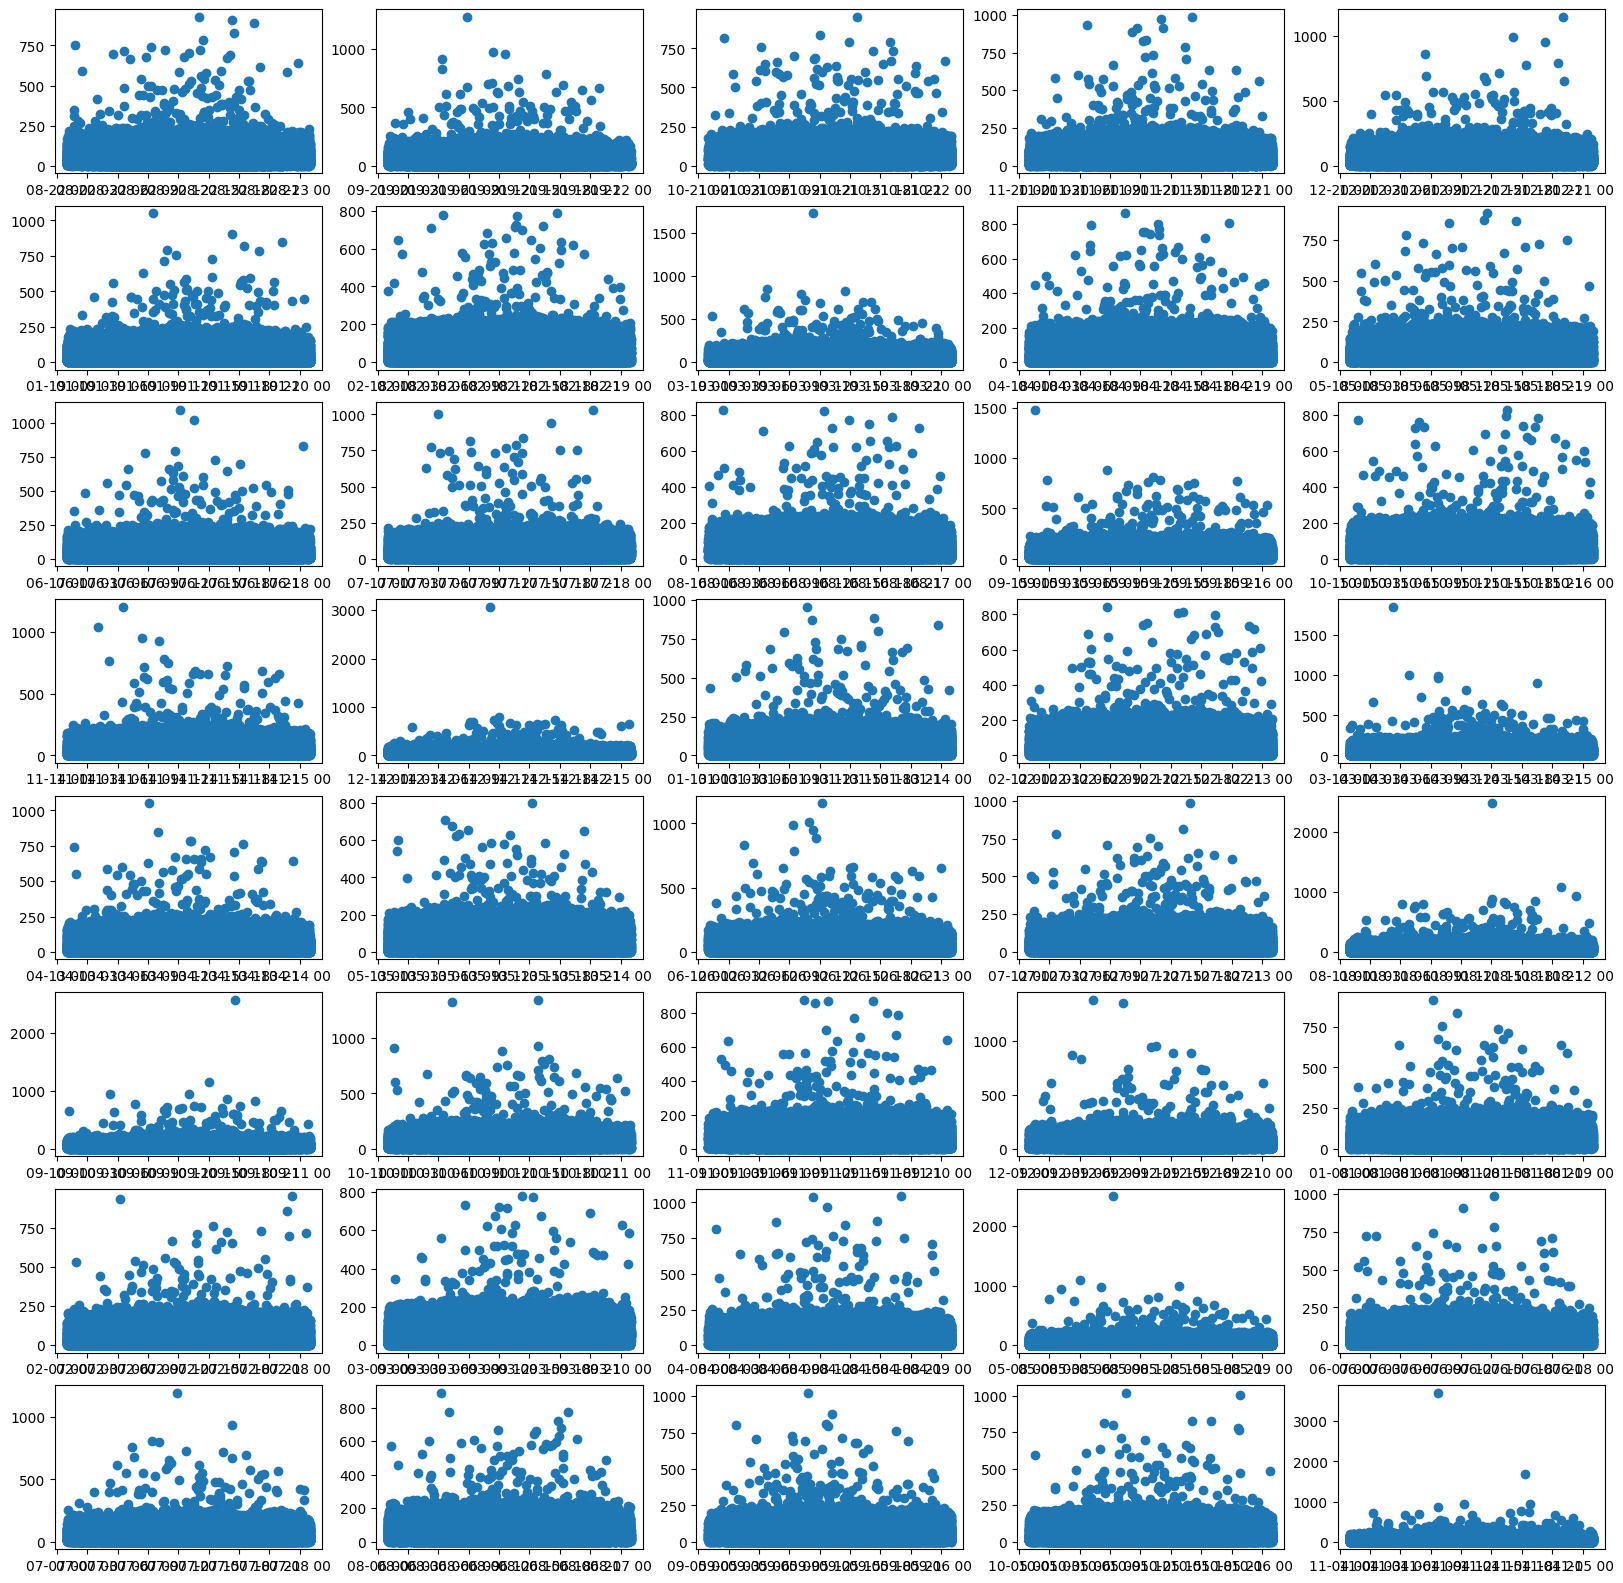

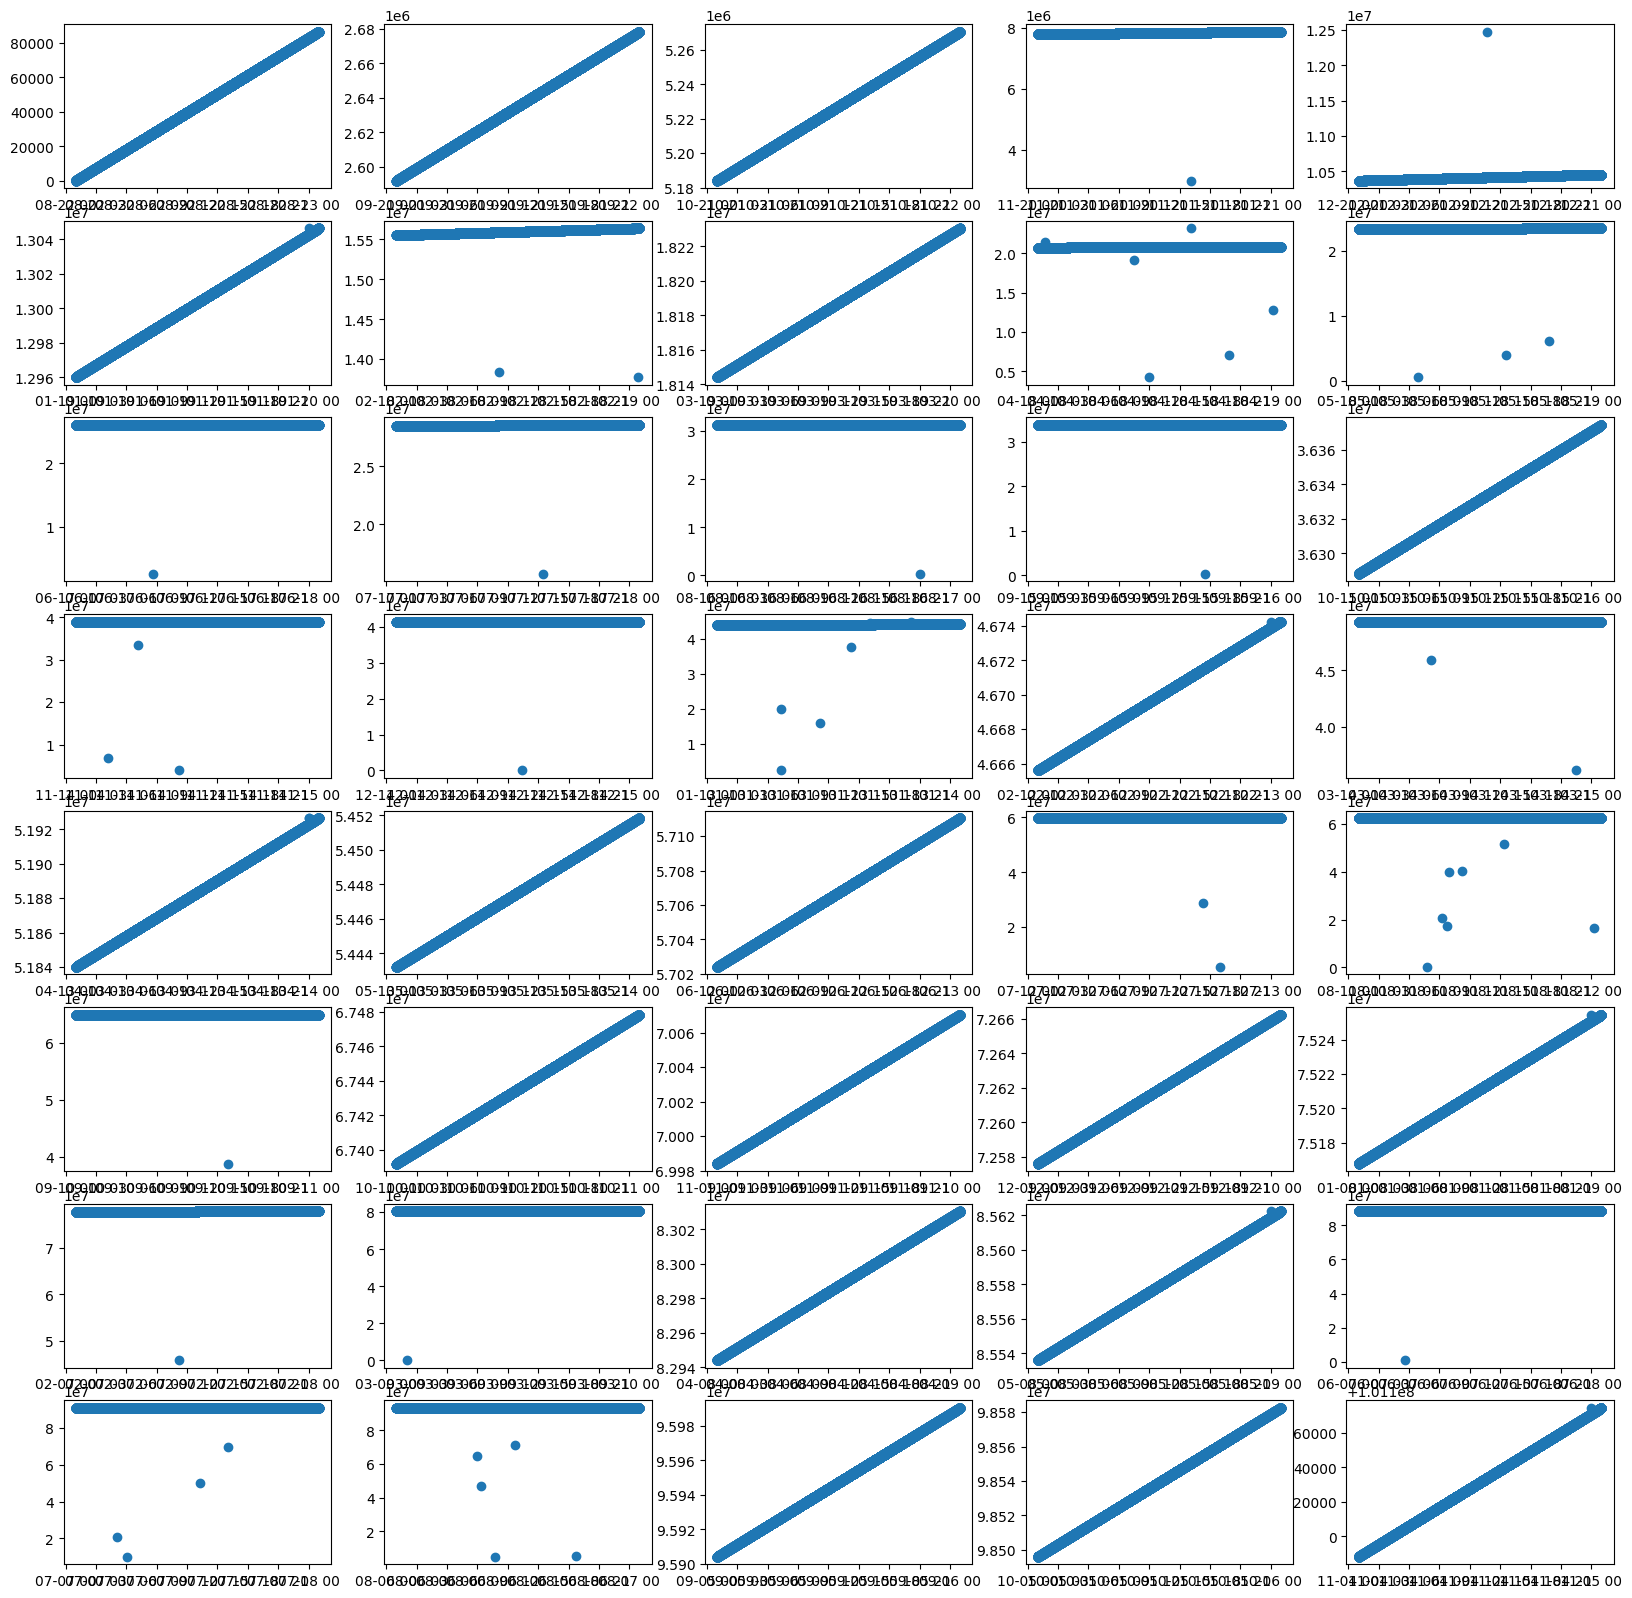

In [ ]:
tx_amount, tx_amount_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_seconds, tx_time_seconds_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
n_row, n_col = 0, 0
for data in data_bucket.objects.all():
    df = read_csv(data, n_bytes = 10000000)
    df = df[['tx_datetime', 'tx_amount', 'tx_time_seconds']]
    df.sort_values('tx_datetime', inplace=True)
    tx_amount_ax[n_row, n_col].scatter(fix_date(df['tx_datetime']), df['tx_amount'])
    tx_time_seconds_ax[n_row, n_col].scatter(fix_date(df['tx_datetime']), df['tx_time_seconds'])
    n_row = n_row if n_col + 1 < 5 else n_row + 1
    n_col = n_col + 1 if n_col < 4 else 0

На графиках `tx_amount` видны точки, которые заметно выделяются относительно большинства. Взаимосвязь `tx_time_seconds` и `tx_datetime` носит линейный характер. Скорее всего это какой-то timestamp от определенной даты. Однако есть точки, которые значительно отклоняются от линейной зависимости.

Найдем 99 процентиль `tx_amount`. В дальнейшем будем его использовать для удаления выбросов.

In [ ]:
precentiles = pd.DataFrame()
for data in data_bucket.objects.all():
    df = read_csv(data, n_bytes = 10000000)
    df = df[df['tx_amount'].notna() & df['tx_time_seconds'].notna()] # Удаляем пропуски
    df['tx_datetime'] = fix_date(df['tx_datetime']) # Фиксим некорректные даты
    df['date'] = df['tx_datetime'].dt.date
    df = df[['date','tx_amount',  'tx_time_seconds']]
    df = df.groupby('date', as_index=False).agg(tx_amount_lower=('tx_amount', lambda x: np.percentile(x, 5)),
                                                        tx_amount_median=('tx_amount', lambda x: np.percentile(x, 50)),
                                                        tx_amount_higher=('tx_amount', lambda x: np.percentile(x, 95)))
    df['file'] = data.key
    precentiles = pd.concat([precentiles, df])

In [ ]:
q_95_tx_amount = precentiles.groupby('date', as_index=False)['tx_amount_higher'].median()

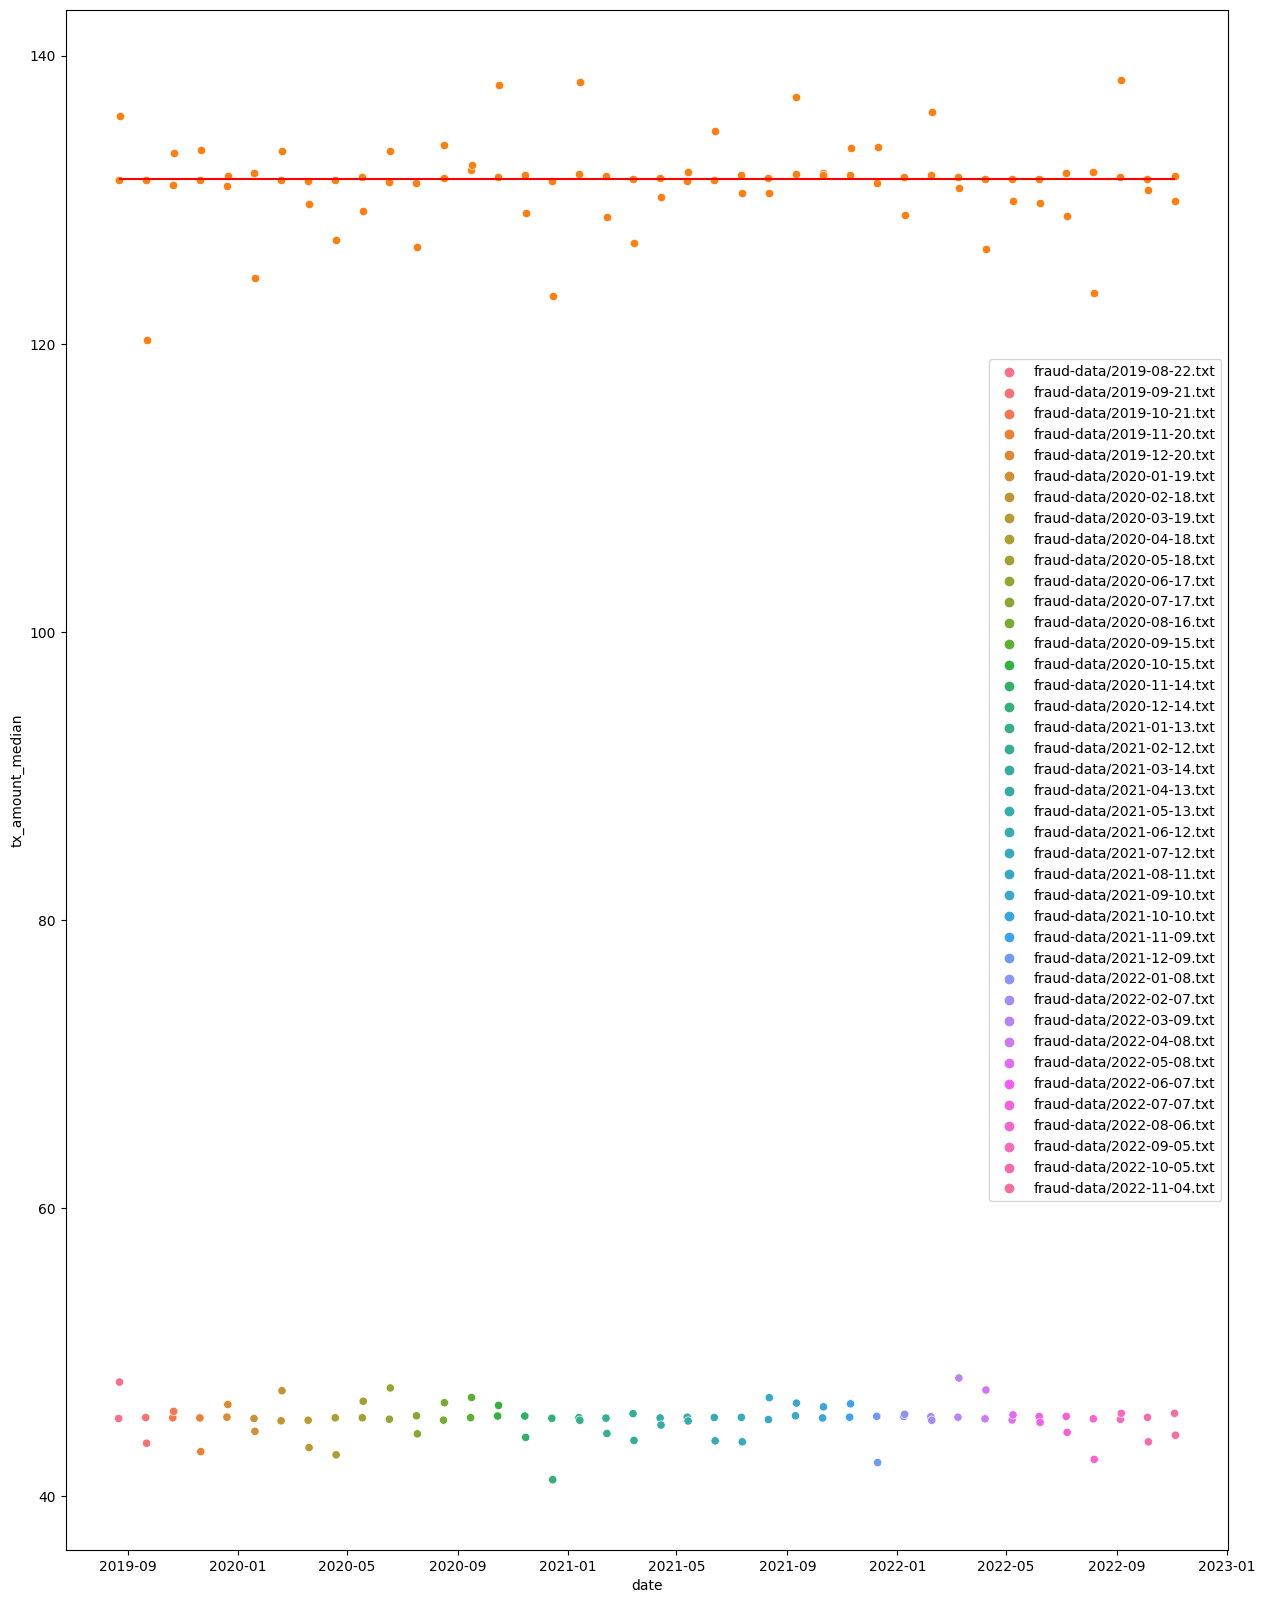

In [ ]:
fig, ax = plt.subplots(figsize=(15,20))

sns.scatterplot(precentiles, x='date', y='tx_amount_median', hue='file', ax=ax)
sns.scatterplot(q_95_tx_amount, x='date', y='tx_amount_higher', ax=ax)
ax.hlines(y=precentiles['tx_amount_higher'].median(), xmin=precentiles['date'].min(), xmax=precentiles['date'].max(), colors='red')

In [ ]:
tx_amount_95 = precentiles['tx_amount_higher'].median()
print(f'95 процениль tx_amount: {tx_amount_95:.2f}')

95 процениль tx_amount: 131.45


Попробуем найти отклонения от линейной связи `tx_time_seconds` и `tx_datetime` с помощью линейной регрессии. Будем убирать остатки, которые больше 4 стандартных отклонений от среднего.

In [ ]:
df = read_csv(data, n_bytes = 10000000)
df = df[df['tx_amount'].notna() & df['tx_time_seconds'].notna()] # Удаляем пропуски
df['tx_datetime'] = fix_date(df['tx_datetime']) # Фиксим некорректные даты

<Axes: >

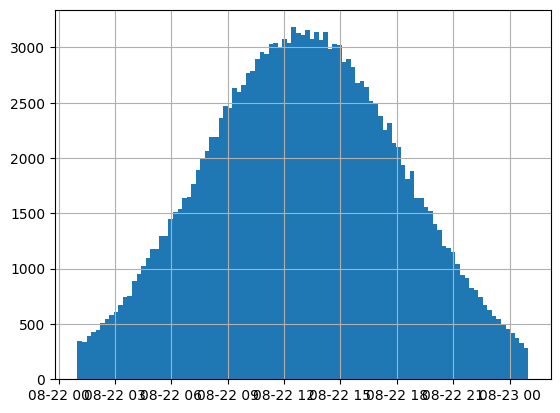

In [ ]:
from sklearn.linear_model import LinearRegression


def find_time_outliers(df, n=4):
    model = LinearRegression()
    model.fit(X=np.expand_dims(df['tx_datetime'].values.astype(np.int64), axis=0).T // 10 ** 9, y=df['tx_time_seconds'])
    residuals = model.predict(np.expand_dims(df['tx_datetime'].values.astype(np.int64), axis=0).T // 10 ** 9) - df['tx_time_seconds']
    border = n * residuals.std()
    return residuals.abs() < border if border > 0 else np.ones(residuals.shape[0], dtype=bool)

df[find_time_outliers(df)]['tx_datetime'].hist(bins=99)

# Файлы были почищены в распределенной среде с помощью spark и загружены в другой бакет
# Проверим файлы после преобразования



In [ ]:
data_bucket = s3.Bucket('otus-mlops-data-clear')

========= 2019-08-22.parquet ========
========= 2019-09-21.parquet ========
========= 2019-10-21.parquet ========
========= 2019-11-20.parquet ========
========= 2019-12-20.parquet ========
========= 2020-01-19.parquet ========
========= 2020-02-18.parquet ========
========= 2020-03-19.parquet ========
========= 2020-04-18.parquet ========
========= 2020-05-18.parquet ========
========= 2020-06-17.parquet ========
========= 2020-07-17.parquet ========
========= 2020-08-16.parquet ========
========= 2020-09-15.parquet ========
========= 2020-10-15.parquet ========
========= 2020-11-14.parquet ========
========= 2020-12-14.parquet ========
========= 2021-01-13.parquet ========
========= 2021-02-12.parquet ========
========= 2021-03-14.parquet ========
========= 2021-04-13.parquet ========
========= 2021-05-13.parquet ========
========= 2021-06-12.parquet ========
========= 2021-07-12.parquet ========
========= 2021-08-11.parquet ========
========= 2021-09-10.parquet ========
========= 20

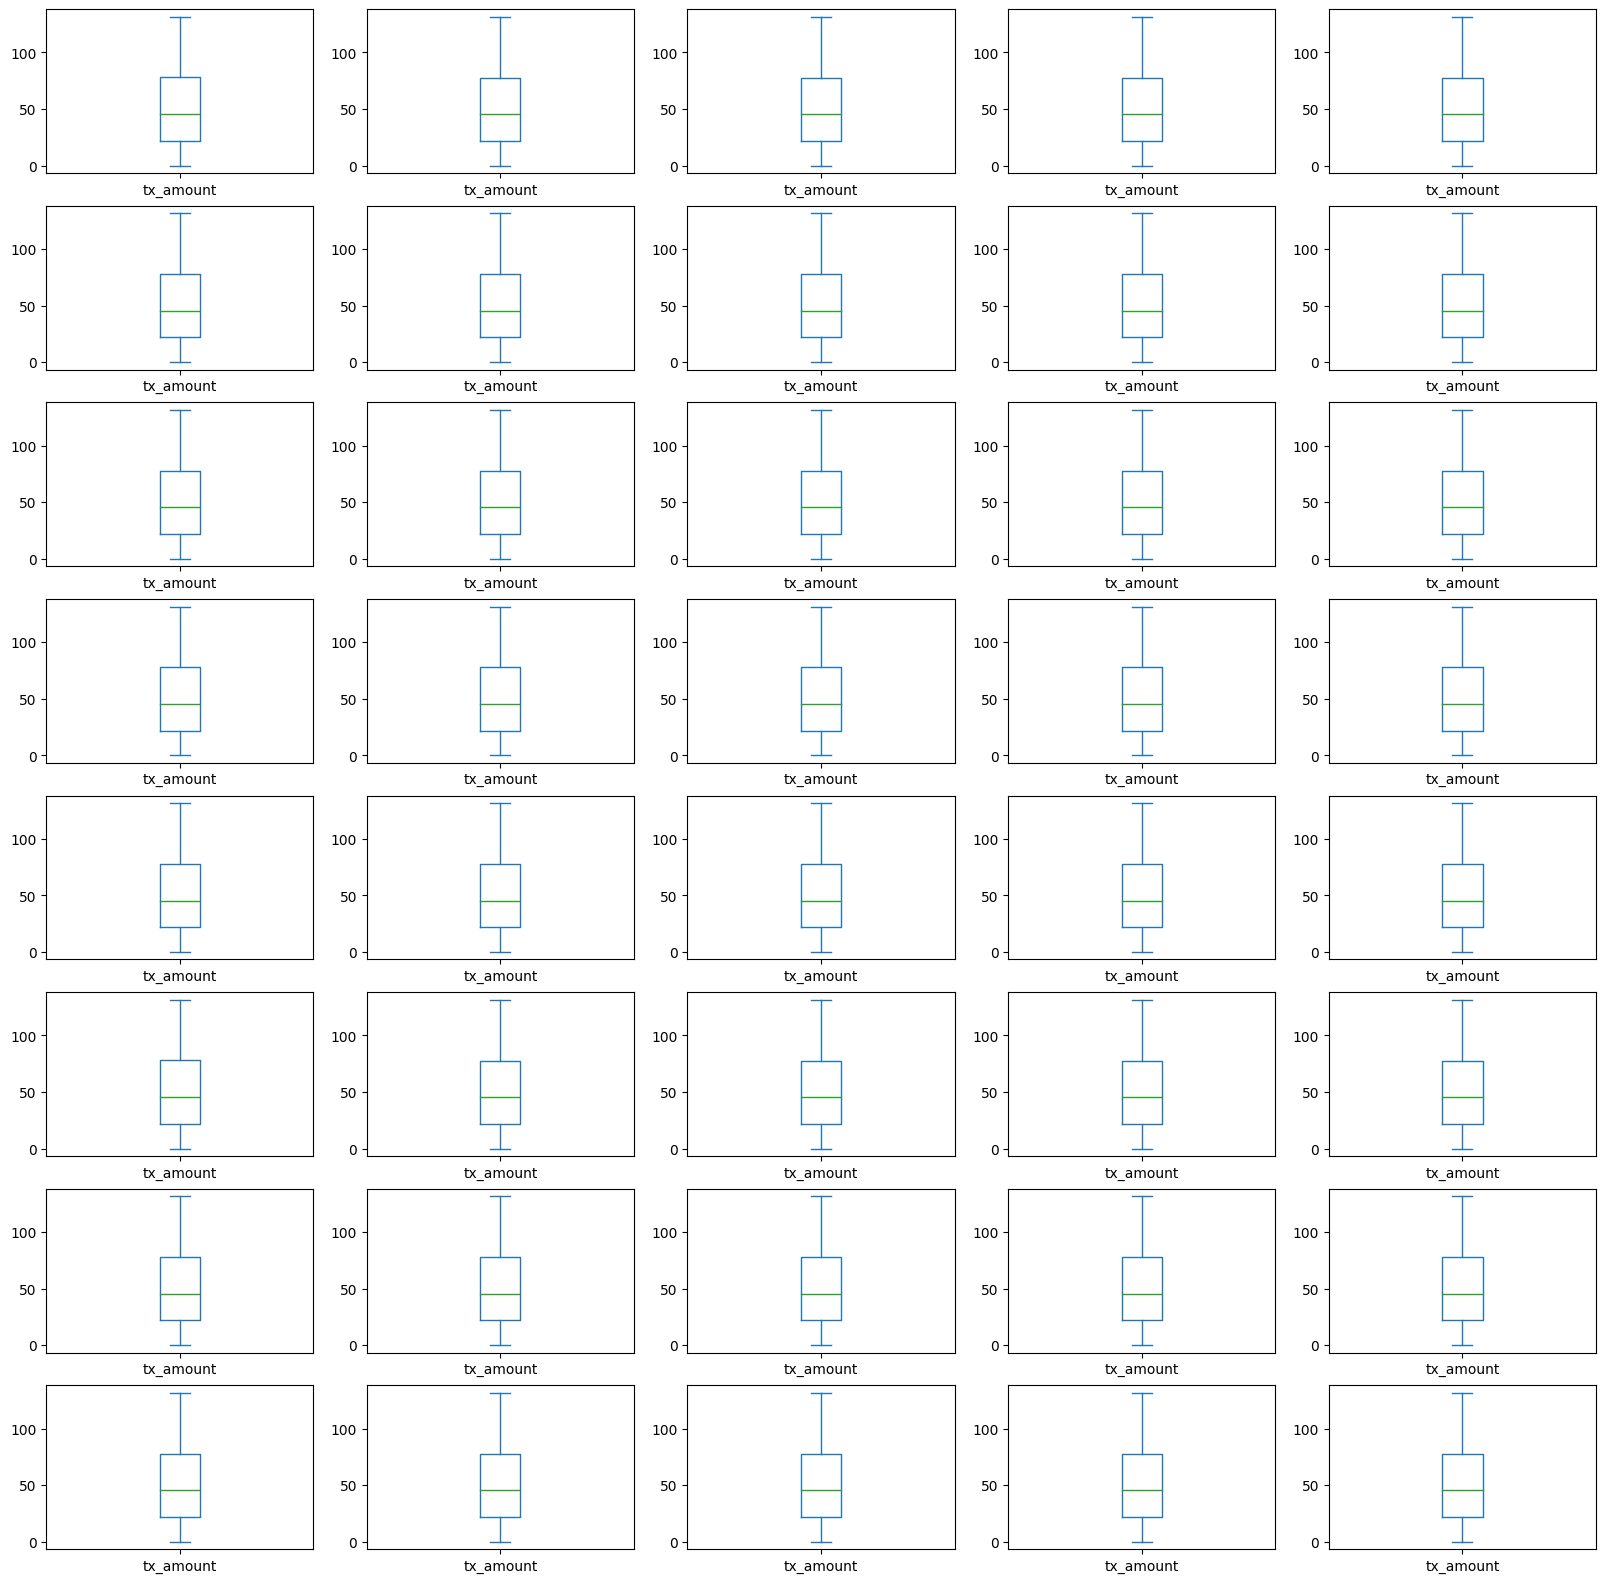

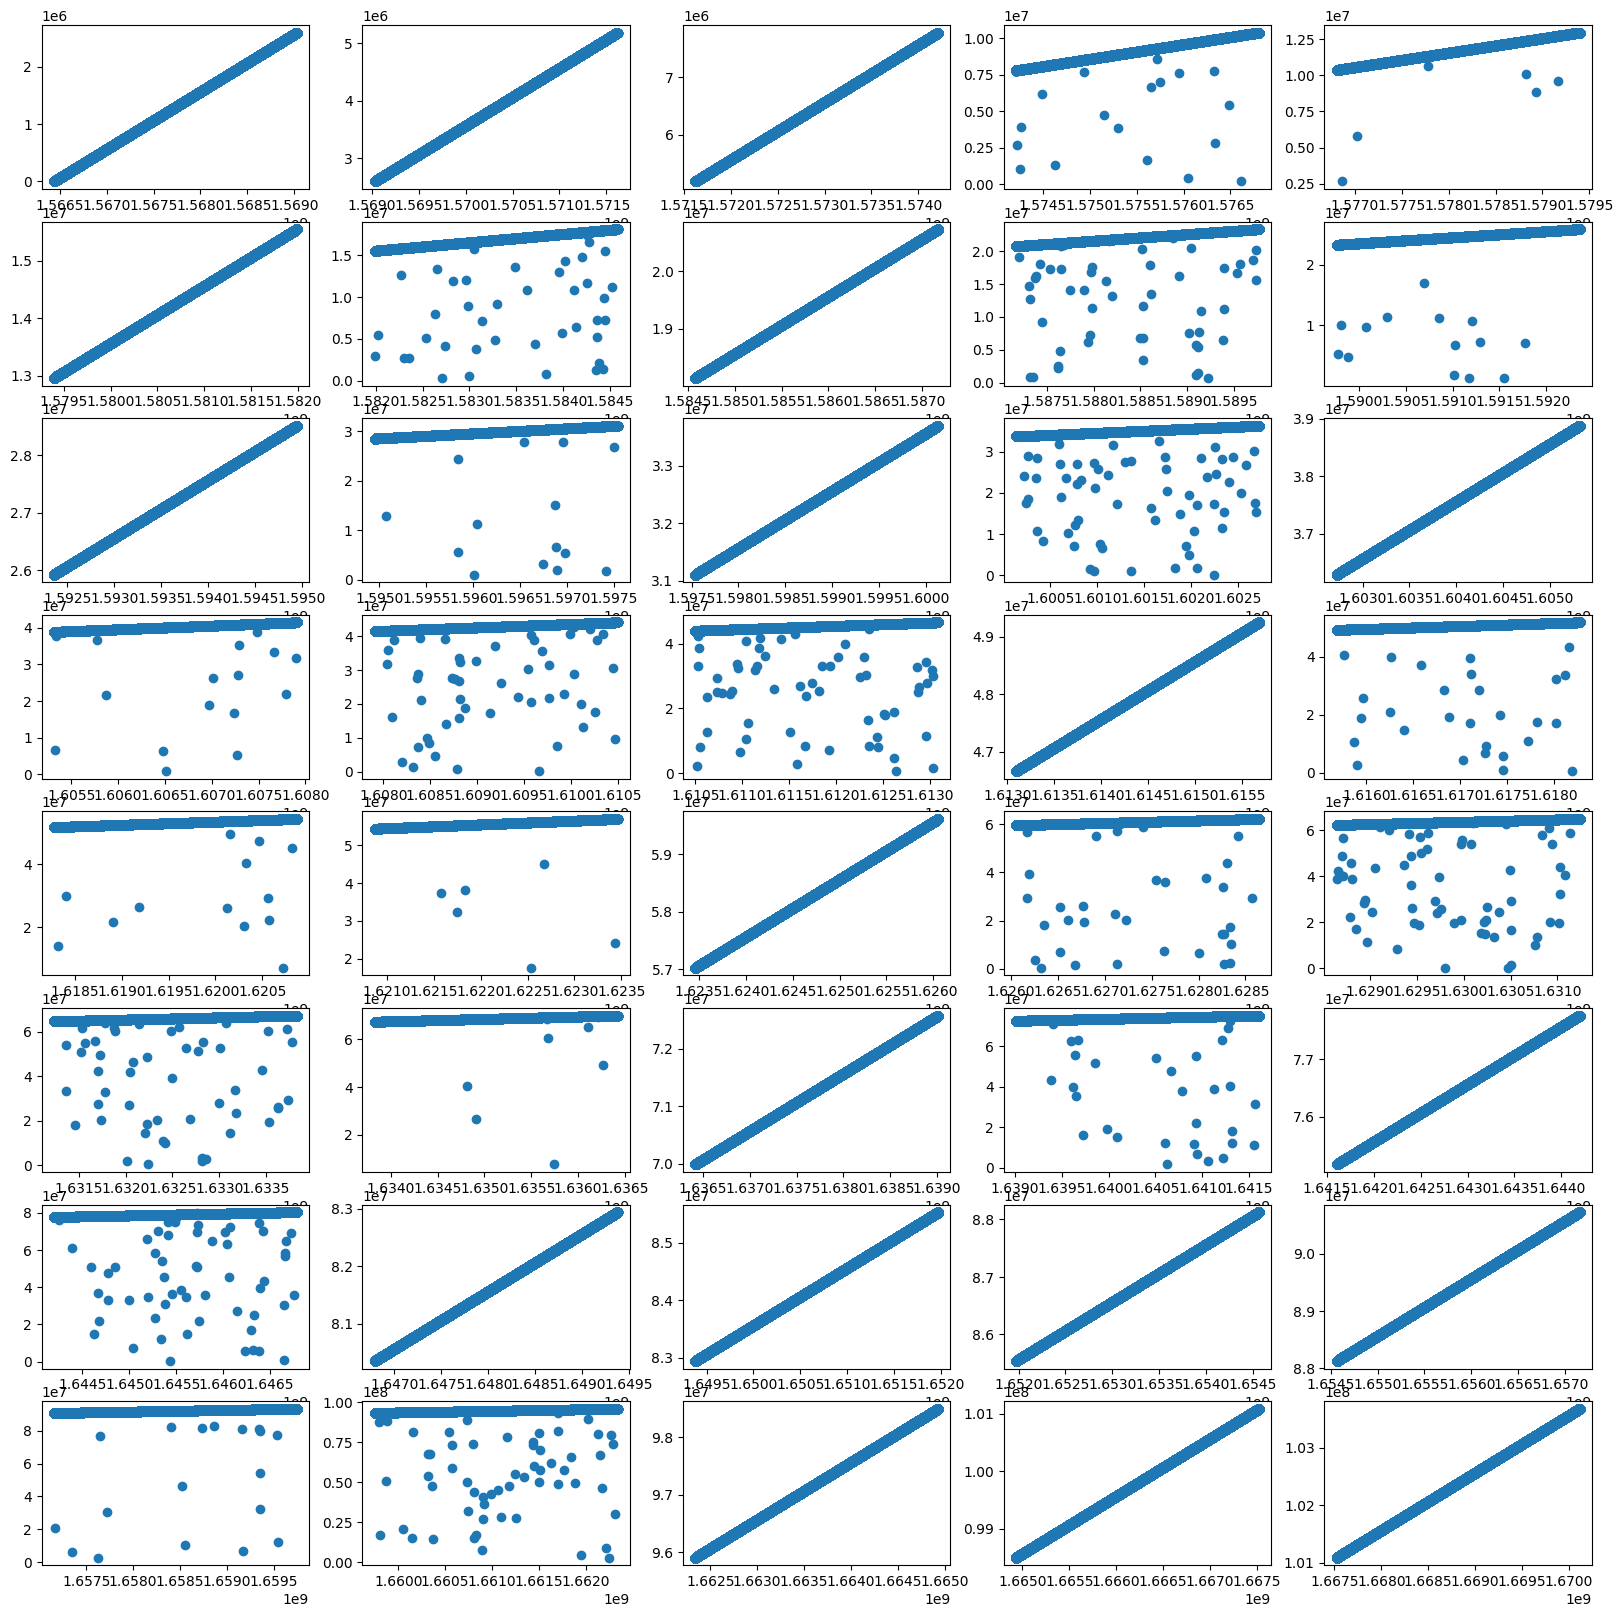

In [ ]:
tx_amount, tx_amount_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
tx_time_seconds, tx_time_seconds_ax = plt.subplots(nrows=8, ncols=5, figsize=(20,20))
n_row, n_col = 0, 0
for data in data_bucket.objects.all():
    print(f'========= {data.key} ========')
    buffer = io.BytesIO()
    object = s3.Object('otus-mlops-data-clear', data.key)
    object.download_fileobj(buffer)
    df = pd.read_parquet(buffer).sample(frac=0.05)
    df = df[['tx_datetime', 'tx_amount', 'tx_time_seconds']]
    df.sort_values('tx_datetime', inplace=True)
    df['tx_amount'].plot.box(ax=tx_amount_ax[n_row, n_col])
    tx_time_seconds_ax[n_row, n_col].scatter(df['tx_datetime'], df['tx_time_seconds'])
    n_row = n_row if n_col + 1 < 5 else n_row + 1
    n_col = n_col + 1 if n_col < 4 else 0

В поле `tx_amount` стало меньше экстремальных значений. К сожалению, в `tx_time_seconds` "вылезли" другие экстремальные значения, которые меньше 4 сигм. Со стороны это поле выглядит линейно зависимым с `tx_datetime` с некоторой долей ошибок, поэтому, скорее всего в будущем, оно не будет информативно для алгоритмов ML.

Таким образом, в результате анализа данных были найдены следующие моменты, на которые нужно обратить внимание:
1. Разный тип данных в `terminal_id`, решение: привести к int64.
2. Ошибки в поле `tx_datetime`, решение: если присутствует 24 час, то считаем это следующим днем.
3. Наличие выбросов в полях `tx_amount` и `tx_time_seconds`. Решение: `tx_amount` - ограничение данных 95 процентилем, `tx_time_seconds` - замена на значение, предсказанное линейной регрессией.
4. Линейная зависимость `tx_time_seconds` и `tx_datetime`.

# Обучение модели (new)

In [ ]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import io
import datetime as dt
import numpy as np
import seaborn as sns
import warnings
import seaborn as sns

warnings.simplefilter('ignore')
s3 = boto3.resource('s3',
                endpoint_url='https://storage.yandexcloud.net',
                region_name = 'ru-central1',
                aws_access_key_id = ..., # your key
                aws_secret_access_key = ..., # your key
                )

In [ ]:
def read_csv(s3obj, n_bytes = 10000):
    txt = data.get().get('Body').read(n_bytes).decode()
    header = txt.split('\n')[0]
    body = '\n'.join(txt.split('\n')[1:-1])
    header = [i.strip() for i in header.replace('#', '').split('|')]
    df= pd.read_csv(io.StringIO(body),sep=',', engine = 'python', names=header)
    return df

In [ ]:
# data_bucket = s3.Bucket('otus-mlops-data-clear')
data_bucket = s3.Bucket('otus-mlops-hw2')

In [ ]:
for data in data_bucket.objects.all():
    if data.key.split('.')[-1] == 'parquet':
        print(f'========= {data.key} ========')
        buffer = io.BytesIO()
        object = s3.Object('otus-mlops-hw2', data.key)
        object.download_fileobj(buffer)
        df = pd.read_parquet(buffer)
        break
    else:
        df = read_csv(data, n_bytes = 10000000)

In [ ]:
df = df.iloc[:1000000, :]

In [ ]:
# df_ = df.copy()
df = df_.copy()

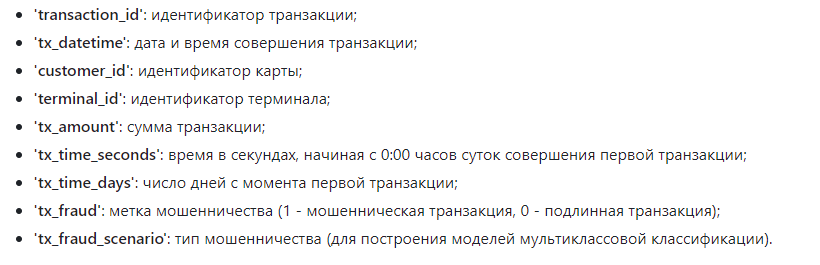

In [ ]:
df.head()

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
0,0,1566460263,0.0,711.0,70.910004,24663.0,0.0,0.0,0.0
1,1,1566454237,0.0,0.0,90.550003,18637.0,0.0,0.0,0.0
2,2,1566504333,0.0,753.0,35.380001,68733.0,0.0,0.0,0.0
3,3,1566462093,0.0,0.0,80.410004,26493.0,0.0,0.0,0.0
4,4,1566468377,1.0,981.0,102.830002,32777.0,0.0,0.0,0.0


<Axes: ylabel='Type'>

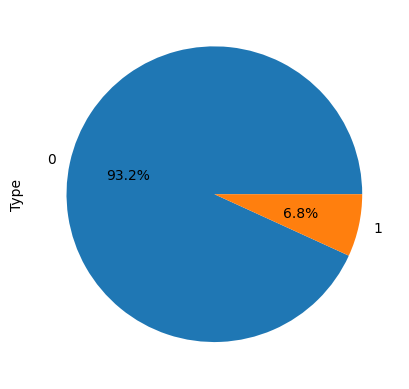

In [ ]:
df.groupby('tx_fraud').size().plot(kind='pie',
                                       y = "tx_fraud",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [ ]:
def fix_date(d, verbose=False):
    dates = []
    e = 0
    f = 0
    for i in d:
        try:
            date, time = i.split()
            Y = date.split('-')[0]
            m = date.split('-')[1]
            d = date.split('-')[2]
            H = time.split(':')[0]
            M = time.split(':')[1]
            S = time.split(':')[2]
            if H == '24':
                H = '23'
                f += 1
            dates.append(np.datetime64(f'{Y}-{m}-{d} {H}:{M}:{S}') + np.timedelta64(1, 'h'))
        except:
            dates.append(np.datetime64('NaT'))
            e += 1
    if verbose:
        print(f'Обнаружено {e + f} ошибок в дате, исправлено {f}')
    return dates

fix_date(['2023-03-03 14:23:41', '2023-03-03 24:23:41', '23'], True)

Обнаружено 2 ошибок в дате, исправлено 1


[numpy.datetime64('2023-03-03T15:23:41'),
 numpy.datetime64('2023-03-04T00:23:41'),
 numpy.datetime64('NaT')]

In [ ]:
df['tx_datetime'] = fix_date(df['tx_datetime'])

In [ ]:
# Salt
df['tx_datetime'] = [i + dt.timedelta(milliseconds=np.random.randint(1, 999)) for i in df['tx_datetime']]

In [ ]:
# F.lag("val").over(w))
df.sort_values(['tx_datetime', 'customer_id'], inplace=True)

In [ ]:
df.set_index('tx_datetime', inplace=True)

In [ ]:
# New features

# df['weekend'] = np.where(df['tx_datetime'].dt.day_of_week.isin([5,6]), 1, 0)
# df['day_night'] = np.where(df['tx_datetime'].dt.hour.isin(range(9)), 1, 0)

# скользящее среднее числа транзакций по каждой карте
df['avg_transaction_count_1'] = df.groupby('customer_id', as_index=False)['tranaction_id'].transform(lambda x: x.rolling('1D').count())
df['avg_transaction_count_7'] = df.groupby('customer_id', as_index=False)['tranaction_id'].transform(lambda x: x.rolling('7D').count())
df['avg_transaction_count_30'] = df.groupby('customer_id', as_index=False)['tranaction_id'].transform(lambda x: x.rolling('30D').count())

# скользящее среднее суммы транзакций по каждой карте
df['avg_transaction_mean_1'] = df.groupby('customer_id', as_index=False)['tx_amount'].transform(lambda x: x.rolling('1D').mean())
df['avg_transaction_mean_7'] = df.groupby('customer_id', as_index=False)['tx_amount'].transform(lambda x: x.rolling('7D').mean())
df['avg_transaction_mean_30'] = df.groupby('customer_id', as_index=False)['tx_amount'].transform(lambda x: x.rolling('30D').mean())

# скользящее среднее числа транзакций по каждому терминалу
df['avg_transaction_terminal_id_count_1'] = df.groupby('terminal_id', as_index=False)['tranaction_id'].transform(lambda x: x.rolling('1D').count())
df['avg_transaction_terminal_id_count_7'] = df.groupby('terminal_id', as_index=False)['tranaction_id'].transform(lambda x: x.rolling('7D').count())
df['avg_transaction_terminal_id_count_30'] = df.groupby('terminal_id', as_index=False)['tranaction_id'].transform(lambda x: x.rolling('30D').count())

# скользящее среднее числа мошеннических операций по каждому терминалу
# df['sum_fraud_terminal_id_count_1'] =  df.groupby('terminal_id', as_index=False)['tx_fraud'].transform(lambda x: x.rolling('1D').mean())
# df['sum_fraud_terminal_id_count_7'] = df.groupby('terminal_id', as_index=False)['tx_fraud'].transform(lambda x: x.rolling('7D').mean())
# df['sum_fraud_terminal_id_count_30'] = df.groupby('terminal_id', as_index=False)['tx_fraud'].transform(lambda x: x.rolling('30D').mean())

In [ ]:
df.sort_values(['tx_datetime'], inplace=True)

In [ ]:
df = df.drop(columns=['tranaction_id', 'customer_id', 'terminal_id', 'tx_fraud_scenario'])

In [ ]:
train  = df.sample(frac=0.9)
test = df[~df.index.isin(train.index)]

In [ ]:
# Upsampling
train = pd.concat([train[train['tx_fraud'] == 1].sample((train['tx_fraud'] == 0).sum(), replace=True),
                train[train['tx_fraud'] == 0]])

In [ ]:
train['tx_fraud'].value_counts()

1    127598
0    127598
Name: tx_fraud, dtype: int64

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}


clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(train.drop(columns='tx_fraud'), train['tx_fraud'])

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
predict_proba = grid_search.predict_proba(test.drop(columns='tx_fraud'))
predict = grid_search.predict(test.drop(columns='tx_fraud'))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

for i in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]:
    print(i, f1_score(test['tx_fraud'],
     (predict_proba[:, 0] < i).astype(float)))

0.0001 0.31494578029231496
0.001 0.31494578029231496
0.01 0.31494578029231496
0.1 0.31494578029231496
0.2 0.31494578029231496
0.3 0.31494578029231496
0.4 0.31494578029231496
0.5 0.31494578029231496
0.6 0.31494578029231496
0.7 0.31494578029231496
0.8 0.31494578029231496
0.9 0.31494578029231496
0.95 0.31494578029231496
0.99 0.31494578029231496
0.999 0.31494578029231496


In [ ]:
print(classification_report(test['tx_fraud'],
                            predict
     )
)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     14105
           1       0.32      0.31      0.31      1071

    accuracy                           0.90     15176
   macro avg       0.63      0.63      0.63     15176
weighted avg       0.90      0.90      0.90     15176



In [ ]:
for f, imp in zip(grid_search.best_estimator_.feature_names_in_, grid_search.best_estimator_.feature_importances_):
    print(f'{f: <50} {imp:.5f}')

tx_amount                                          0.18084
tx_time_seconds                                    0.25503
tx_time_days                                       0.00000
avg_transaction_count_1                            0.00813
avg_transaction_count_7                            0.00915
avg_transaction_count_30                           0.00918
avg_transaction_mean_1                             0.07917
avg_transaction_mean_7                             0.07753
avg_transaction_mean_30                            0.07073
avg_transaction_terminal_id_count_1                0.06580
avg_transaction_terminal_id_count_7                0.07581
avg_transaction_terminal_id_count_30               0.16864


In [ ]:
fpr, fnr = [], []
for _ in range(100):
    predict = grid_search.predict(test.drop(columns='tx_fraud').sample(frac=1.0, replace=True))
    predict_proba = grid_search.predict_proba(test.drop(columns='tx_fraud'))
    tp = sum((test['tx_fraud'] == 1) & (predict == 1))
    tn = sum((test['tx_fraud'] == 0) & (predict == 0))
    fp = sum((test['tx_fraud'] == 0) & (predict == 1))
    fn = sum((test['tx_fraud'] == 1) & (predict == 0))
    fpr.append(tp / (tp + fn))
    fnr.append(tn / (tn + fp))

Text(0.5, 1.0, 'FPR')

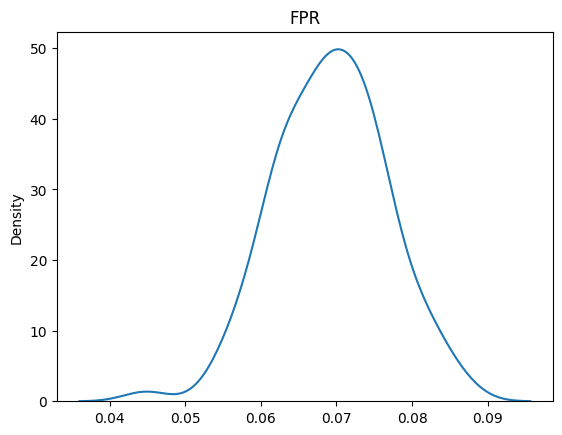

In [ ]:
sns.kdeplot(fpr).set_title('FPR')

Text(0.5, 1.0, 'FNR')

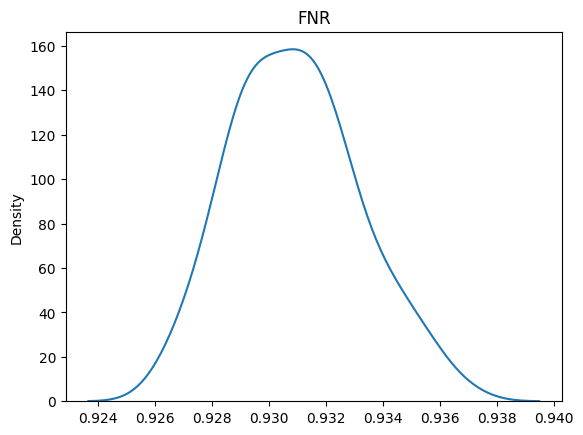

In [ ]:
sns.kdeplot(fnr).set_title('FNR')